In [1]:
#importing all the necessary and allowed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction to the Problem
The goal of this model is to predict a system’s probability of getting infected by various families of malware, based on different properties of that system. The telemetry data containing these properties and the system infections was generated by threat reports collected by system's antivirus software.

# Data Loading
We will now load the dataset and inspect to make sure that everything is loaded correctly like all the columns are present etc

In [2]:
file_path = '/kaggle/input/System-Threat-Forecaster'

train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
sub = pd.read_csv('/kaggle/input/System-Threat-Forecaster/sample_submission.csv')

train.columns

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'RealTimeProtectionState',
       'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
       'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA',
       'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID',
       'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID',
       'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutio

# Exploratory Data Analysis

Feature types and number of missing values, we will impute these when we make preprocessing pipelines.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [4]:
(train.isnull().mean() * 100).sort_values(ascending=False)

SMode                             0.981
CityID                            0.623
RegionIdentifier                  0.559
IsGamer                           0.559
InternalBatteryNumberOfCharges    0.515
                                  ...  
DeviceFamily                      0.000
ProductName                       0.000
HasOpticalDiskDrive               0.000
PowerPlatformRole                 0.000
target                            0.000
Length: 76, dtype: float64

Since the number of missing values is vert few we will handle missing values by imputing as opposed to dropping since we can preserve rows by doing so.

# Feature Engineering

Here 
'DateAS' : Malware signature dates ,
'DateOS' : timestamps for OSVersion which gives the time that the OS was last updated

The new feature represents the age of new system's age after updating

In [5]:
train['DateAS'] = pd.to_datetime(train['DateAS'])
train['DateOS'] = pd.to_datetime(train['DateOS'])
train['SystemAge'] = (train['DateAS'] - train['DateOS']).dt.days

test['DateAS'] = pd.to_datetime(test['DateAS'])
test['DateOS'] = pd.to_datetime(test['DateOS'])
test['SystemAge'] = (test['DateAS'] - test['DateOS']).dt.days

train.drop(columns=['DateAS'], inplace=True)
test.drop(columns=['DateAS'], inplace=True)
train.drop(columns=['DateOS'], inplace=True)
test.drop(columns=['DateOS'], inplace=True)


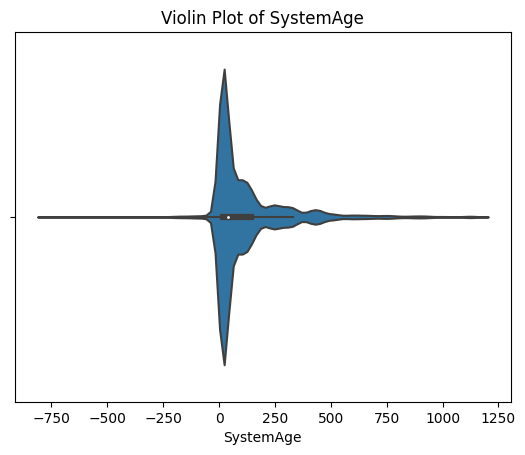

In [6]:
#violin plot of the new dataset
sns.violinplot(x='SystemAge', data = train)
plt.xlabel('SystemAge')
plt.title('Violin Plot of SystemAge')
plt.show()


Such a distribution indicates popular chasis' probably had some new update at specific times quite close to the date that the data was collected.

Note that a negative age indicates that a malware was detected before the OS was updated, although we do not find as many instances of this occuring. (approximately 1.5%)

In [7]:
(train['SystemAge'].value_counts()<0).count()/len(train['SystemAge'])
#dont need to check for null values since we know there are none

0.01548

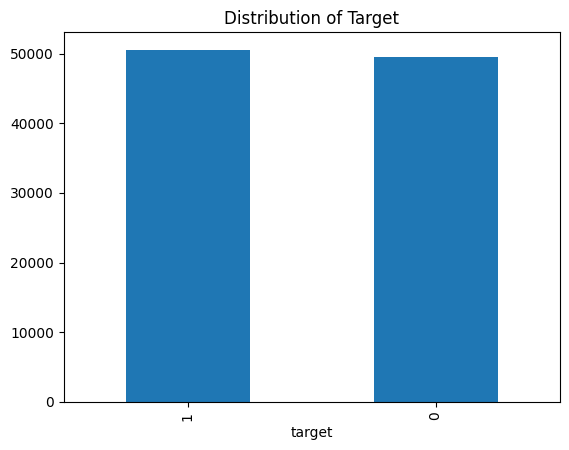

In [8]:
train['target'].value_counts().plot(kind='bar')
plt.title("Distribution of Target")
plt.show()


Dataset is fairly balenced doesnt require SMOTE

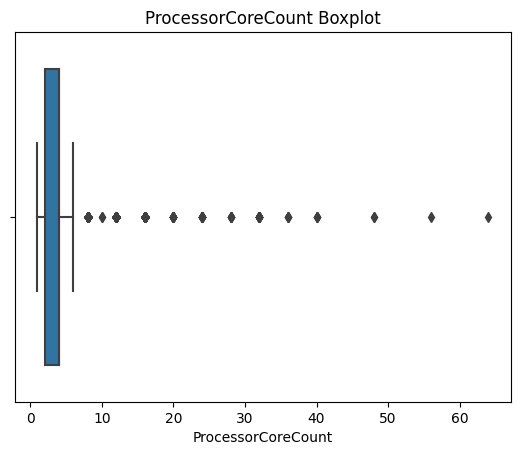

In [9]:
sns.boxplot(x=train['ProcessorCoreCount'])
plt.title("ProcessorCoreCount Boxplot")
plt.show()


Most machines have 2 or 4 cores (which is typical for consumer devices) quite a few have 12 and some upto 60

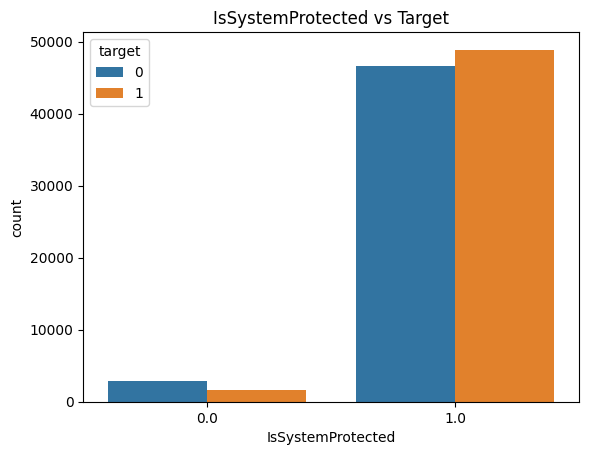

In [10]:
sns.countplot(x='IsSystemProtected', hue='target', data=train)
plt.title("IsSystemProtected vs Target")
plt.show()


Most machines have some sort of protection software intalled. Unusually, protected systems have a slightly higher rate of getting infected.


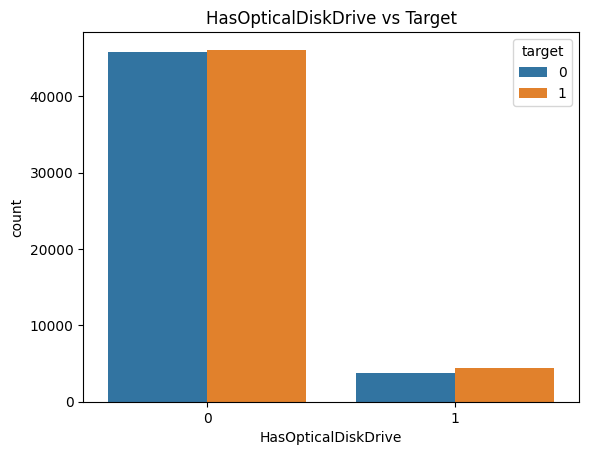

In [11]:
sns.countplot(x='HasOpticalDiskDrive', hue='target', data=train)
plt.title("HasOpticalDiskDrive vs Target")
plt.show()


Most machines don't have an optical disk drive.

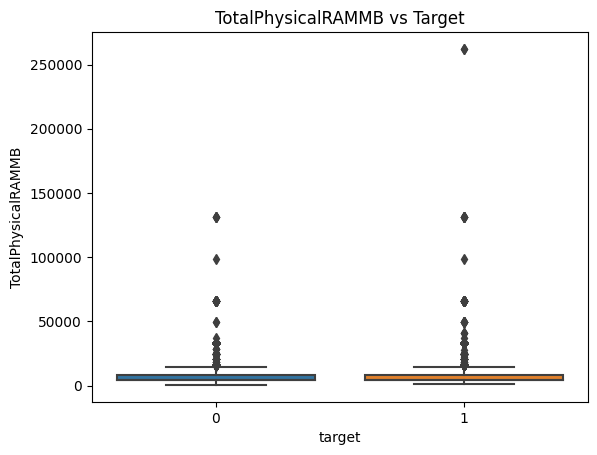

In [12]:
sns.boxplot(x='target', y='TotalPhysicalRAMMB', data=train)
plt.title("TotalPhysicalRAMMB vs Target")
plt.show()


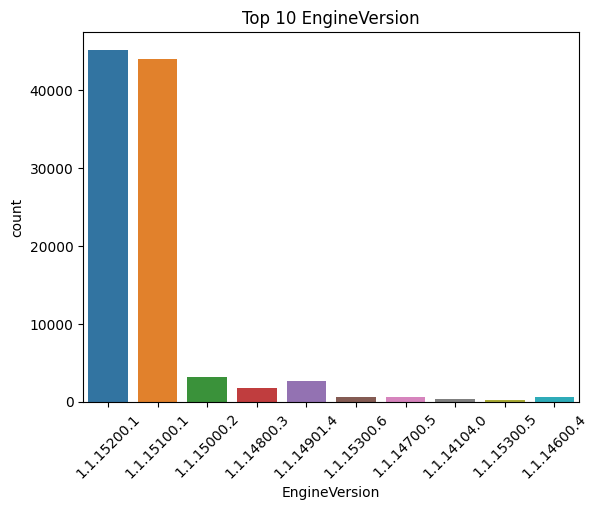

In [13]:
top_versions = train['EngineVersion'].value_counts().nlargest(10).index
sns.countplot(x='EngineVersion', data=train[train['EngineVersion'].isin(top_versions)])
plt.title("Top 10 EngineVersion")
plt.xticks(rotation=45)
plt.show()


most of the engine versions are ```1.1.15200.1``` and ```1.1.15100.1```

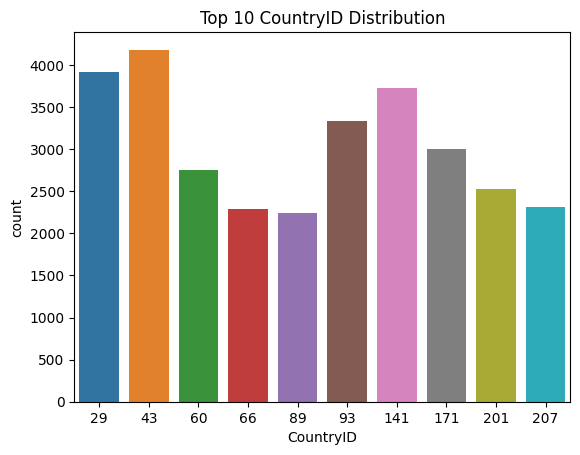

In [14]:
top_10_countries = train['CountryID'].value_counts().nlargest(10).index
sns.countplot(x='CountryID', data=train[train['CountryID'].isin(top_10_countries)])
plt.title("Top 10 CountryID Distribution")
plt.show()


In [15]:
train['ChassisType'].value_counts()
#most machines are Notebooks

ChassisType
Notebook               59459
Desktop                20818
Laptop                  7811
Portable                4126
AllinOne                2269
Convertible              966
MiniTower                952
Detachable               611
LowProfileDesktop        559
Other                    535
HandHeld                 526
UNKNOWN                  454
SpaceSaving              324
Tablet                   163
Tower                    129
MainServerChassis        111
Unknown                   59
LunchBox                  39
MiniPC                    34
RackMountChassis          17
BusExpansionChassis       13
SubNotebook               11
0                          4
30                         4
CompactPCI                 1
SubChassis                 1
MultisystemChassis         1
35                         1
Name: count, dtype: int64

# Preprocessing

In [16]:
# dropping columns that dont have more than one unique values
cols_to_drop = ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled', 'MachineID']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)


In [17]:
# cheking if the columns are dropped
train.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion',
       'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'SMode', 'IEVersionID',
       'FirewallEnabled', 'EnableLUA', 'MDC2FormFactor', 'DeviceFamily',
       'OEMNameID', 'OEMModelID', 'ProcessorCoreCount',
       'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB',
       'PrimaryDiskType', 'SystemVolumeCapacityMB', 'HasOpticalDiskDrive',
       'TotalPhysicalRAMMB', 'ChassisType', 'PrimaryDisplayDiagonalInches',
       'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'PowerPlatformRole',
       'InternalBatteryNumberOfC

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
#replaces all categories but top n (based on frequency) to 'Other' 
class TopNEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, n):
        self.n = n
        self.top_n_ = None

    def fit(self, X, y=None):
        X = self._convert_to_series(X)
        freq = X.value_counts()
        self.top_n_ = freq.nlargest(self.n).index
        return self

    def transform(self, X):
        X = self._convert_to_series(X)
        return X.where(X.isin(self.top_n_), other='Other').values.reshape(-1, 1)

    def _convert_to_series(self, X):
        """
        Converts X to a one-dimensional pandas Series.
        If X is (n_samples, 1) or (n_samples,), make it a Series.
        """
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError("TopNEncoder expects a single column DataFrame.")
            X = X.iloc[:, 0]  # get the single column as a Series
        elif isinstance(X, np.ndarray):
            # Flatten if it's (n_samples, 1)
            if len(X.shape) == 2 and X.shape[1] == 1:
                X = X.ravel()
            # Now X is shape (n_samples,)
            X = pd.Series(X)
        else:
            # If it's already a Series or some other type, you may need more checks
            # but typically Series or array are the main cases.
            pass
        return X

top_n_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('top_n', TopNEncoder(n=10)),  # or n=15, etc.
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [19]:
from sklearn.preprocessing import StandardScaler
numeric_median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_mode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

binary_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


In [20]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_map_ = {}

    def fit(self, X, y=None):
        X = self._convert_to_series(X)
        freq = X.value_counts() / len(X)
        self.freq_map_ = freq.to_dict()
        return self

    def transform(self, X):
        X = self._convert_to_series(X)
        return X.map(self.freq_map_).fillna(0).values.reshape(-1, 1)

    def _convert_to_series(self, X):
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError("FrequencyEncoder expects a single column.")
            X = X.iloc[:, 0]
        elif isinstance(X, np.ndarray):
            if len(X.shape) == 2 and X.shape[1] == 1:
                X = X.ravel()
            X = pd.Series(X)
        return X

id_freq_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_encoder', FrequencyEncoder())
])


In [21]:
transformers = [] 
numeric_cols_median = [
    'NumAntivirusProductsInstalled',
    'SystemAge',
    'OSBuildRevisionOnly',
    'PrimaryDisplayResolutionVertical',
    'SystemVolumeCapacityMB',
    'PrimaryDisplayResolutionHorizontal',
    'OSBuildNumber',
    'PrimaryDisplayDiagonalInches',
    'OSBuildNumberOnly',
    'PrimaryDiskCapacityMB',
    'ProcessorCoreCount',
    'TotalPhysicalRAMMB',
    'InternalBatteryNumberOfCharges',
    'NumAntivirusProductsEnabled',
]

ordinal = [
    
    
]

binary_cols = [
    'IsAlwaysOnAlwaysConnectedCapable',
    'IsTouchEnabled',
    'IsPassiveModeEnabled',
    'IsVirtualDevice',
    'IsPenCapable',
    'SMode',
    'IsSecureBootEnabled',
    'IsPortableOS',
    'HasTpm',
    'FirewallEnabled',
    'HasOpticalDiskDrive',
    'IsGamer',
    'IsSystemProtected',
    'DeviceFamily',
    'ProductName'  #only has two values
]


id_type = [
    'FirmwareManufacturerID',
    'OEMNameID',
    'OEMModelID',
    'FirmwareVersionID',
    'LocaleEnglishNameID',
    'IEVersionID',
    'ProcessorModelID',
    'AntivirusConfigID',
    'OSInstallLanguageID',
    'OSUILocaleID'
]

for col in id_type:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
for col in id_type:
    transformers.append(
        (f"id_freq_{col}", id_freq_pipeline, [col])
    )


cat_mode = [
    'OSProductSuite',
    'EnableLUA', # 3 unique values only
    'ProcessorManufacturerID', #has very few (4) unique values
    'RealTimeProtectionState',
    'FlightRing',
    'OSVersion',
    'OSEdition',
    'OSBranch',
    'LicenseActivationChannel',
    'OsPlatformSubRelease',
    'PowerPlatformRole',
    'Processor',
    'AutoUpdateOptionsName',
    'PrimaryDiskType',
    'OSSkuFriendlyName',
    'OSArchitecture',
    'OSInstallType',
    'MDC2FormFactor',
]

#selected columns have very few values in the class of <top n categories
top_n = [
    'CityID',
    'NumericOSVersion',
    'SignatureVersion',
    'GeoRegionID',
    'OSBuildLab',
    'EngineVersion',
    'OSGenuineState',   
    'CountryID',
    'PlatformType',     
    'SKUEditionName',   
    'AppVersion',
    'ChassisType'
]

#converting top- n columns to strings

for col in top_n:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

#add the top-n encoding pipeline for each column
for col in top_n:
    transformers.append(
        (f"top_n_{col}", top_n_pipeline, [col])
    )


In [22]:
train['ProcessorManufacturerID'].value_counts()

ProcessorManufacturerID
5.0     88180
1.0     11727
10.0        5
3.0         3
Name: count, dtype: int64

In [23]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
    ('num_median', numeric_median_pipeline, numeric_cols_median),
    ('binary_cat', binary_cat_pipeline, binary_cols),
    ('cat_mode', cat_mode_pipeline, cat_mode),
    # ('top_n_cat', top_n_pipeline, top_n)
    ] + transformers,
    remainder='drop'
)


## Fitting preprocessor and verifying

In [24]:
# Separate target from training
y_train = train['target']
X_train = train.drop(columns=['target'])

# Also drop 'target' from test if it exists
# (sometimes test doesn't have target at all)
X_test = test.drop(columns=['target'], errors='ignore')

# Now fit/transform on X only
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


The warning is just a heads up that the model is encountering new categories at the inference time, this is usually okay to leave as is. We can check the size of the new dataset just to be sure though.

In [25]:
print(train.shape, X_train_processed.shape)

(100000, 71) (100000, 268)


We have learnt how one hot encoders work and blow up the size of the data, so this is expected. Lets verify this using a calculation

In [26]:
#Inspect how many columns each part produces

total_cols = 0
for name, trans, cols in preprocessor.transformers_:
    # Skip dropped or empty groups
    if trans == 'drop' or len(cols) == 0:
        continue

    # Extract just the columns handled by this transformer
    subset = X_train[cols]

    # Transform that subst alone (the pipeline/transform is already fitted)
    subset_t = trans.transform(subset)

    # Count how many columns we now have
    n_cols = subset_t.shape[1]
    total_cols += n_cols

    print(f"Transformer '{name}' on columns {cols} -> {n_cols} columns")

print(f"\nSum of columns from all transformers: {total_cols}")
print(f"Columns in final output: {X_train_processed.shape[1]}")


Transformer 'num_median' on columns ['NumAntivirusProductsInstalled', 'SystemAge', 'OSBuildRevisionOnly', 'PrimaryDisplayResolutionVertical', 'SystemVolumeCapacityMB', 'PrimaryDisplayResolutionHorizontal', 'OSBuildNumber', 'PrimaryDisplayDiagonalInches', 'OSBuildNumberOnly', 'PrimaryDiskCapacityMB', 'ProcessorCoreCount', 'TotalPhysicalRAMMB', 'InternalBatteryNumberOfCharges', 'NumAntivirusProductsEnabled'] -> 14 columns
Transformer 'binary_cat' on columns ['IsAlwaysOnAlwaysConnectedCapable', 'IsTouchEnabled', 'IsPassiveModeEnabled', 'IsVirtualDevice', 'IsPenCapable', 'SMode', 'IsSecureBootEnabled', 'IsPortableOS', 'HasTpm', 'FirewallEnabled', 'HasOpticalDiskDrive', 'IsGamer', 'IsSystemProtected', 'DeviceFamily', 'ProductName'] -> 15 columns
Transformer 'cat_mode' on columns ['OSProductSuite', 'EnableLUA', 'ProcessorManufacturerID', 'RealTimeProtectionState', 'FlightRing', 'OSVersion', 'OSEdition', 'OSBranch', 'LicenseActivationChannel', 'OsPlatformSubRelease', 'PowerPlatformRole', 'Pro

Since the expected number of columns matches the resultant, we can now move forward

In [27]:
from sklearn.model_selection import train_test_split


X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_processed,  # not the raw X_train
    y_train,
    test_size=0.2,
    random_state=1
)

Looking for null values

In [28]:
df_part = pd.DataFrame(X_train_part)
print(df_part.isnull().sum())  # check for NaNs in each column
print("Rows with NaN:", df_part.isnull().any(axis=1).sum())


0    0
dtype: int64
Rows with NaN: 0


# Model Training

## Random Forest
Since we have tabular data we will start off by Random Forest Classifier

Accuracy: 0.6086
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      9968
           1       0.61      0.62      0.62     10032

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



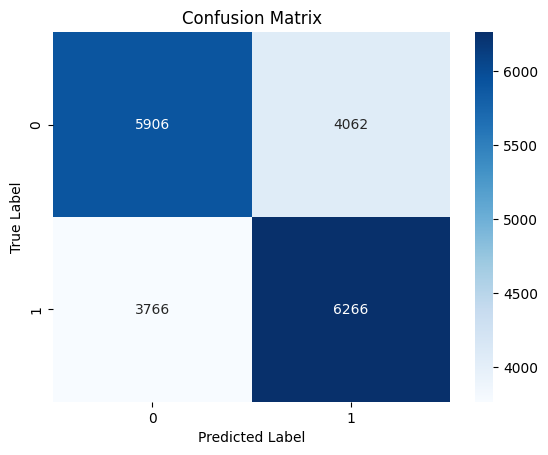

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(random_state=1)
clf.fit(X_train_part, y_train_part)
y_pred = clf.predict(X_val_part)

print("Accuracy:", accuracy_score(y_val_part, y_pred))
print(classification_report(y_val_part, y_pred))
sns.heatmap(confusion_matrix(y_val_part, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Logistic Regression

Logistic Regression Accuracy: 0.6134


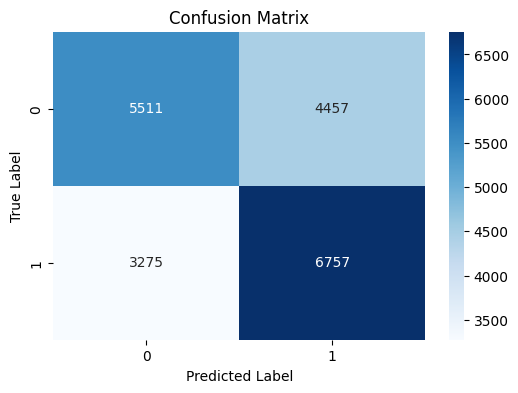

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

lr_clf = LogisticRegression(random_state=1, max_iter=2000)
lr_clf.fit(X_train_part, y_train_part)

y_pred_lr = lr_clf.predict(X_val_part)

print("Logistic Regression Accuracy:", accuracy_score(y_val_part, y_pred_lr))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val_part, y_pred_lr), annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###  Hyperparametertuning

In [31]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    # note that lbfgs doesn't support l1 penalty, so we stick to liblinear or saga
    'solver': ['liblinear', 'saga']
}

# Initialize Logistic Regression (no fixed hyperparameters yet)
lr_base = LogisticRegression(max_iter=2000, random_state=1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid,
    scoring='accuracy',  # since the competition takes accuracy :)
    cv=5,                # 5-fold cross-validation
    n_jobs=-1            # Use all available CPU cores
)

# Fit the grid search on the training data
grid_search.fit(X_train_part, y_train_part)

# Check best parameters and best CV score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate on the validation set
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_val_part)

print("\nValidation Accuracy:", accuracy_score(y_val_part, y_pred))
print(classification_report(y_val_part, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_part, y_pred))


Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.61395

Validation Accuracy: 0.6142
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      9968
           1       0.60      0.68      0.64     10032

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000

Confusion Matrix:
 [[5510 4458]
 [3258 6774]]


# LightGBM

In [32]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the LightGBM model with best params
lgb_best = lgb.LGBMClassifier(
    learning_rate=0.1,
    max_depth=-1,
    n_estimators=100,
    num_leaves=31,
    random_state=42
)

# Fit the model on your training split
lgb_best.fit(X_train_part, y_train_part)

# Predict on validation
y_pred_val = lgb_best.predict(X_val_part)

# Evaluate
val_acc = accuracy_score(y_val_part, y_pred_val)
print("Validation Accuracy (LightGBM best params):", val_acc)
print("Classification Report:")
print(classification_report(y_val_part, y_pred_val))
print("Confusion Matrix:")
print(confusion_matrix(y_val_part, y_pred_val))


[LightGBM] [Info] Number of positive: 40493, number of negative: 39507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506162 -> initscore=0.024651
[LightGBM] [Info] Start training from score 0.024651
Validation Accuracy (LightGBM best params): 0.62025
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9968
           1       0.61      0.67      0.64     10032

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000

Confusion Matrix:
[[5717 4251]
 [3344 668

# XGBoost

XGBoost Accuracy: 0.61615
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9968
           1       0.61      0.66      0.63     10032

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000

Confusion Matrix:
[[5697 4271]
 [3406 6626]]


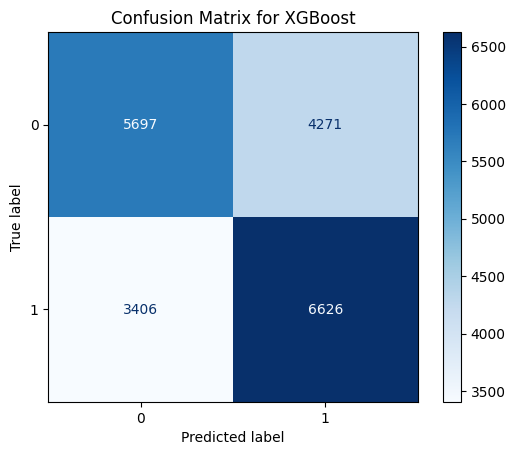

In [33]:
import xgboost as xgb

# Training XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_part, y_train_part)

# Make predictions on the validation set
y_pred_xgb = xgb_clf.predict(X_val_part)

# Print accuracy and classification report
print("XGBoost Accuracy:", accuracy_score(y_val_part, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_val_part, y_pred_xgb))

# Compute the confusion matrix
cm = confusion_matrix(y_val_part, y_pred_xgb)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix with a blue colormap
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost")
plt.show()


### Stacking

In [34]:
from sklearn.ensemble import StackingClassifier

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_clf = lgb.LGBMClassifier(random_state=42)

stack_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('lgb', lgb_clf)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3  # 3-fold cross-validation for base estimators
)

# Fit the stacking model on your training split
stack_clf.fit(X_train_part, y_train_part)

# Predict on validation
y_pred_stack = stack_clf.predict(X_val_part)

# Evaluate
acc_stack = accuracy_score(y_val_part, y_pred_stack)
print("Stacking (XGB + LGB) Accuracy:", acc_stack)
print("Classification Report (Stacking):")
print(classification_report(y_val_part, y_pred_stack))

print("Confusion Matrix (Stacking):")
print(confusion_matrix(y_val_part, y_pred_stack))

[LightGBM] [Info] Number of positive: 40493, number of negative: 39507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506162 -> initscore=0.024651
[LightGBM] [Info] Start training from score 0.024651
[LightGBM] [Info] Number of positive: 26995, number of negative: 26338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 225
[LightGBM] [Info] 

# Hyperparameter tuning best Model

In [35]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Baseline default parameters for LightGBM
default_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'max_depth': -1
}

# Initialize the LightGBM classifier with default parameters
lgb_clf = lgb.LGBMClassifier(**default_params)

# Define the parameter grid including the default values
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500],
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 10, 20, 30]
}

# Set up GridSearchCV (5-fold cross-validation, using accuracy for scoring)
grid_search = GridSearchCV(estimator=lgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit grid search on the training data
grid_search.fit(X_train_processed, y_train)

# Print the best parameters and cross-validation accuracy
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 50525, number of negative: 49475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
Best parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 40}
Best CV accuracy: 0.6247800000000001


# Submission

LightBGM implements gradient boosting descision trees which are known to [excel on structured (tabular) data](https://medium.com/geekculture/why-tree-based-models-beat-deep-learning-on-tabular-data-fcad692b1456). Hence the final model comes to no surprise.

I would like to extend my gratitude to the mentors of MLP Project (Jan term 2025) and the mentors of MLP theory course, MLF theory course and TDS at IITM (BSc Data Science)

In [36]:
X_test_processed = preprocessor.transform(test)

grid_search.fit(X_train_processed, y_train)

best_model = grid_search.best_estimator_

test_preds = best_model.predict(X_test_processed)

submission = pd.DataFrame({
    'id': test.index,  
    'target': test_preds
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print(submission.head())

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 50525, number of negative: 49475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
Submission file created: submission.csv
   id  target
0   0       1
1   1       0
2   2       1
3   3       0
4   4       0
